In [1]:
#Importing the things
import numpy as np
from numpy import linalg as LA
import math
import matplotlib.pyplot as plt
from pylab import *
import scipy.ndimage as ndi
import scipy
import seaborn as sns
import copy

"""
For 209 final
1) Cell types (via SL) and diff plasticity rules
2) Use modularity instead of evecs for now
3) Read Triplett

Future
1) Activation function changing over dev
2) SL cells serving different roles in different times (first as quick learner, then as noise introduction)
3) Timing (recurrence between time steps, different delays to activation [delay inh activation -> two peaks], etc)
4) Read Hopfield
5) Complex evecs/evals, and as positive control (in a simplified network), initialize a matrix with explicit evec/evals, give it those inputs?

Notes

Current problem
- during first 5 trials, the hub-iest neurons immediate strengthen, and everyone else weakens... and then only hub-y cells are active from then on
    *solution = try making subtype of cell types only exc (first 30 cells), and then have broad lateral inh (second 20 cells?)... that way we don't just have a small subnetwork of hub neurons
    - look at eigenvectors of the matrix... see how separable they are?
    - try initializing a less random matrix with explicit eigenvectors, then give it those inputs?
- check resulting weights, see evecs
    - since matrix isn't super symmetric, evecs likely not ortho...
    - this is largely bc the nonfiring neurons don't have their weights tuned to each other
    - PRESENT DIFFERENT ODOR BLOCKS such that different neurons can fire!
- add some global weight decay, otherwise weights can get pinned at 1 (and we need some drift)
    - make weight decay dependent on current weight (and total input to cell, so hub cells are punished)

Tasks (eg. ONE = done or in process, 1 = not started)
ONE) Loop over long time, see if you create a symmetric weight matrix (or a weight matrix with multiple modules) given updating weights based Hebbianly
    - Answer = given my makeshift symmetry index, this seems to be the case in many but not all cases... mostly you just have runaway LTP
TWO) Make LTP/LTD sigmoidal instead of exponential relaxation to +/-1; this favors increasing synapses that are already established but not too strong
    - ie. if synapses are super weak (eg. ASSN weight is 0.01), LTP there might not be realistic bc the input at that synapse might not even drive significant Ca2+ influx. This requires sigmoidal instead of exponential relaxation
    - ie. if synapses are super strong (eg. ASSN weight is 0.9), LTP is probably near saturated. This is already accounted for in exponential relaxation
    - similar thing should hold for inh synapses (eg. if you have a weight of 0, we might not want to immediately have the weight shoot down to -1 exponentially, but rather have small decreases at first)
    - Answer1 = this seems to prevent runaway exc but there's little weight change at all...
        - Problem1 = that's because ASSN weights are low (lambda = 0.2, then zero-meaned), and sigmoidal derivatives are super low in that range
        - Solution1 = make a piece-wise sigmoidal function, where the first half the the function is very broad, so lower ASSN weights can still be increased (see sig() for more details)
    - Answer2 = this seems to work! there are now modular symmetrical/reciprocal weight changes without global runaway exc (ie. only neurons that are firing for a specific input odor are getting weights increased)
        - Problem2 = maybe the LTD is too intense, bc the spiking doesn't change at all (ie. no new neurons are getting recruited to the ensemble, since those connections are getting LTDed immediately)
        - Solution2 (done in THREE) = actually it's more likely that subthreshold firing isn't being rewarded with LTP, so there's no way that a previously non-co-firing pair can start co-firing... maybe need an intermediate category
            1) add inter-odor rest period (in absence of odor and spont act, you have no activity and thus no LTP/LTD, so things will be static w/o some other global downscaling)
            2) add spont act so new connections can form in absence of odor... then see if more neurons are recruited during next odor presentation
THREE) Expose odor in blocks with spont act during rest periods
    - Problem1 = regardless of odor (and even in absence of ASSN), 'v' looks similar... probably because there are just certain neurons that receive overall more or less input
        - actually this might not be a problem... real Pir proably does indeed have neurons that just get overall more input
    - Solution1 = make the average of LOT inputs to each neuron the same


    
    - *add in tonic FFI, act-dep FBI?
    - *make LTD symmetric to implement rough global downscaling
    - *add in temporal directionality of LTP/LTD
        - option 1) if neuron i fires in response to LOT, then it fired BEFORE a neuron j that only fired due to ASSN
        - option 2) make ASSN based on previous time step!!!
    - *make neurons non-linear (ie. rectified for firing rate >= 0)
4) Make a Hopfield network (maybe do this as a new script?)
    - analyze dynamics of post-update symmetric matrix (ie. see if you can eigendecompose and recover network modes, and if those relate to the multiple ensembles)
    - check to see if there are multiple modules 
    - see if I can get integration/short term memory of odor-driven ASSN even after odor stops
5) Discretize spike time instead of treating each input as one spike timeslot
    - make neurons binary +/-1
    - initialize a matrix M = xi*xi^T, where the states xi_i are +/-1
6) Implement developmental stuffs
    *IF SPONT ACT CAN FORM ASSN ENSEMBLES, THEN ADD LOT LTP TO SEE IF THOSE ENSEMBLES TUNE TOGETHER
    - silent synapses?
    - change in membrane properties (more/less excitable over time? integrating total input and tuning excitability? could potentially mimic UNO this way)
    - balance local upscaling with global downscaling (such that overall input to neuron is the same over time)
    - tune LOT weights in act-dep manner as well, after ASSN input is complete (for ensemble tuning)
    - add hub neurons?
    - add switch from GABA-I to GABA-E? add gradual increase in synaptic weights? add LOT LTP rate dropping, whereas ASSN weight stays?
7) Implement more Pir stuff
    - L2a (high LOT, low ASSN), L2b (mid both), L3 (mid LOT, high ASSN; maybe more active earlier on, or spontaneously)
    - APC vs PPC (APC is odor-locked, PPC has overall less LOT but higher ASSN)
    - reward/location etc inputs (maybe as an additional parameter to the input, add whether there's a reward [food/social -> NE/OXT])
    - how do you make it so spont act and odor act look similar?
        - rn odor act dominates... maybe bc |M| > |W|?
        - maybe LOT needs to have its own spont act (to mimic OSN GPCRs, or MTC spont act, etc)

Notes/solved problems
- Problem = the initial W is getting updated along with the new W_new
    - Answer = Python passes lists by reference (aka shallow copy), meaning 'W_new = W' tells python they're the SAME
        - so we have to initialize a new matrix and just copy the values (aka deep copy; ie. 'W_new[:] = W[:]')
- Problem = even if nothing is firing, I still get a slight decrease in weights... seems to be the trunc() altering the floats slightly?
    - Answer = yes, it was because of trunc(); so I calculated W_diff before trunc(), then printed W_new for viewing after trunc()
- Problem = increasing weight linearly by ltp/ltd can lead to runaway synaptic strengthening/weakening
    - Answer = have weight exponentially relax to +/-1, scaled by an ltp/ltd factor
        *note = this is an additional parameter; you can tune both the scaling factor and max/min weight for each individual synapse
    - Answer2 (see TWO above) = actually made this into a piece-wise sigmoidal function instead of exponential; this prevented global runaway LTP
""";

LOT Weights


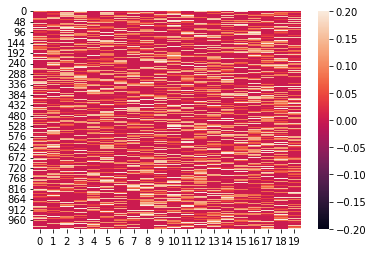

ASSN Weights


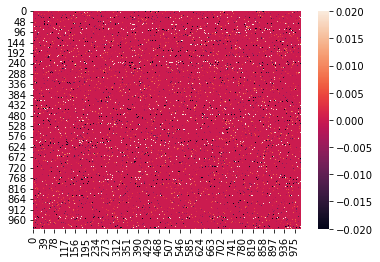

In [2]:
#Initialize activity vector (v), LOT matrix (M), and ASSN matrix (W)

n = 1000 #number of Pir neurons
glom = int(n / 50) #make LOT inputs some % of total ASSN units

#Create vector 'v' of 'n' neurons with initial firing rates r = 0
v = [0] * n

#Create random LOT weight matrix 'M', given n/10 odors (this is drawn from Poisson distribution so mean of weights is 0.3 [which is medium strength] and we don't have too many really high weights)
#M = (np.random.poisson(lam=30, size=(n,glom))/100)
#[got rid of Poi bc weights were too similar and thus all Pir units had similar inputs]

#Create random LOT weight matrix 'M', given n/10 odors, drawn from uniform distribution to increase spread between LOT weights
M = np.random.rand(n,glom);

#Create random ASSN weight matrix 'W' (this is drawn from 0-mean Normal distribution, to make it so ASSN weights start low with some inhibitory ASSN to start with)
W = (np.random.normal(0, 0.15, size=(n,n))); #make sigma small since ASSN likely has lower weights but more overall inputs

#Set certain weights to 0 so the recurrent matrix isn't complete (since Pir neurons are divergent but not all-to-all connected)
#Since ASSN = 100 * LOT, I should make the ASSN connectivity 10% complete so there are 10x more ASSN than LOT inputs

#Sparsify and normalize LOT 'M'
for i in range(len(M)): #loop over all rows of W
    
    shuffled_M = array(range(glom));
    np.random.shuffle(shuffled_M); #create a shuffled array of indices in each row to set to 0

    for j in range(int(len(shuffled_M)*0.5)): #loop over 50% of the shuffled array

        M[i,shuffled_M[j]] = 0 #set 50% of elements in W to 0
    
    #Normalize non-zero elements in each row by its sum weight, and scale so each row has same magnitude as mean of LOT input weights
    row_sum = np.sum(M[i,:]);
    M[i,:] = M[i,:]/row_sum;

#Sparsify and normalize ASSN 'W'
for i in range(len(W)): #loop over all rows of W
    
    shuffled_W = array(range(n));
    np.random.shuffle(shuffled_W); #create a shuffled array of indices in each row to set to 0

    for j in range(int(len(shuffled_W)*0.9)): #loop over 90% of the shuffled array

        W[i,shuffled_W[j]] = 0 #set 90% of elements in W to 0
    
    #Normalize non-zero elements in each row by its sum weight, and scale so each row has same magnitude as mean of LOT input weights
    #row_sum = np.sum(W[i,:]);
    temprow = W[i,:];
    temprow_nonzero = temprow[temprow != 0]; #create a vector of just the non-zero entries in that row
    W[i,:] = W[i,:]/np.sum(temprow_nonzero)*np.mean(M); #we normalize by the sum of just the non-zero entries bc the 0 entries are numerically not 0 or something? and it's fucking up the row sum
    
#Get rid of autapses (DON'T IMPLEMENT THIS LIKE THIS! it will make the rows not normalized in terms of weight)
#zero_diag = (np.identity(n)-1)*(-1) #create a matrix of all 1's except with 0's along diagonal
#W = W*zero_diag #get rid of autapses by doing element-wise multiplication (Python's default multiplication) of W by zero_diag
    
#Softmax each row of M, such that total LOT inputs to each neuron are the same (AND total input from LOT and ASSN are the same, if we also softmax W)
#M = scipy.special.softmax(M,axis=1)
#W = scipy.special.softmax(W,axis=1) - np.mean(scipy.special.softmax(W,axis=1))
#Since inputs to ASSN are now sparse, need to softmax just across the non-zero units (or everything gets collapsed towards the mean, even the 0 elements)
#this is tricky... just normalize each row instead for now... this is now done at the same time as setting certain weights to 0 above

"""
#Test preforming extremely binary modules (ie. separating ensembles into quadrants of the ASSN weight matrix)
W[0:25,0:25] = -1
W[0:25,25:50] = 1
W[25:50,0:25] = 1
W[25:50,25:50] = -1
"""

#Print weight matrices; this is to check if the weights are super small, in which case I need to increase threshold
"""
print('M = ', M, '\n')
print('W = ', W, '\n') #np.trunc(W*100)/100 would display a truncated W, with weights to 2 decimal places
print('mean(W) = ',mean(W));
"""

print("LOT Weights")
ax = sns.heatmap(M, vmin = -0.2, vmax = 0.2)
plt.show()

print("ASSN Weights")
ax = sns.heatmap(W, vmin = -0.02, vmax = 0.02)
plt.show()

LOT weights


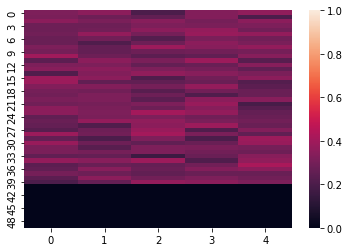

ASSN weights


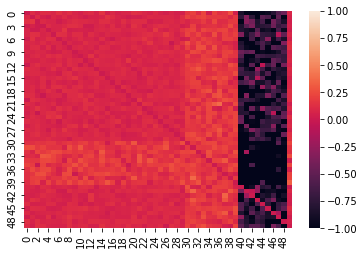

In [300]:
#Initialize activity vector (v), LOT matrix (M), and ASSN matrix (W), WITH DIFFERENT PIR CELL TYPES
#Cells 0-29 are SL-SP, 30-39 are DP, 40-49 are MP

n = 50 #number of Pir neurons; set to 30 so there are 10x more ASSN inputs than LOT inputs
glom = int(n / 10) #make LOT inputs 10% of total ASSN inputs

#Create vector 'v' of 'n' neurons with initial firing rates r = 0
v = [0] * n

#Create random LOT weight matrix 'M', given n/10 odors (this is drawn from Poisson distribution so mean of weights is 0.3 [which is medium strength] and we don't have too many really high weights)
M = (np.random.poisson(lam=30, size=(n,glom))/100)
M[40:99,:] = 0 #make LOT inputs to MP all 0

#Create random ASSN weight matrix 'W' (this is drawn from 0-mean Normal distribution, to make it so ASSN weights start low with some inhibitory ASSN to start with)
W = (np.random.normal(0.08, 0.03, size=(n,n))); #make sigma small since ASSN likely has lower weights but more overall inputs

W[30:40,:] = W[30:40,:]*2 #increase ASSN input magnitudes to DP
W[:,30:40] = W[:,30:40]*2 #increase ASSN output magnitudes from DP
W[30:40,30:40] = (np.random.normal(0.08, 0.03, size=shape(W[30:40,30:40])))*2
W[:,40:49] = -W[:,40:49]*10 #make all outputs from MP negative, and larger

zero_diag = (np.identity(n)-1)*(-1) #create a matrix of all 1's except with 0's along diagonal
W = W*zero_diag #get rid of autapses by doing element-wise multiplication (Python's default multiplication) of W by zero_diag

#Print weight matrices; this is to check if the weights are super small, in which case I need to increase threshold
"""
print('M = ', M, '\n')
print('W = ', np.trunc(W*100)/100, '\n') #display a truncated W, with weights to 2 decimal places
print('mean(W) = ',mean(W));
"""

print("LOT weights")
ax = sns.heatmap(M, vmin = 0, vmax = 1)
plt.show()

print("ASSN weights")
ax = sns.heatmap(W, vmin = -1, vmax = 1)
plt.show()

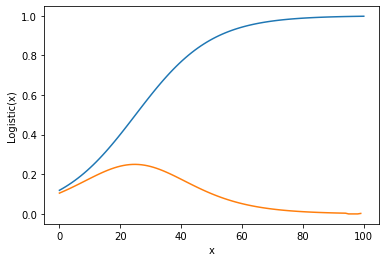

In [3]:
#Create learning rate function for returning LTP/LTD rate as the derivative of a logistic function of current synaptic weight
    #note = logistic is the just the general form of a sigmoidal function
    #derivative of logistic function = since I want to weight increase/decrease to look sigmoidal, I want the LTP/LTD rate to actually be the derivative of a sigmoidal
        #note = since derivative of logistic function is symmetric, I can use the same for LTP and LTD

"""
Think about how to incorporate silent synapses
"""

#Manually define the components of the piece-wise logistic function
x = np.linspace(0, 100, 100);
z = 1/(1 + np.exp(0.08*(-x+25))); #the 0.08 here is by default 1, but that would make the slope really sharp; smaller numbers give rounder functions; +25 is a right-shift of the mid-point of the curve

#Take the derivative of the logistic function
dz = z*(1-z); #can write out the dz/dx and use chain rule to prove this equation is true
dz[95:99] = 0; #cap dz for upper end ASSN weights, so you won't increase past an ASSN weight of +/-1
    #problem with this is that weights will get stuck at > +/- 0.95 since they can't change anymore after they get here...

def sig(w): #Takes in a weight 'w', returns an LTP/LTD rate 'r'
    
    eps = 0.02 #epsilon learning rate

    #On the off-chance that a weight is greater than |1|, force it to be |0.99| so it can index properly into dz
    if w > 1:
        w = 0.99;
    elif w < -1:
        w = -0.99;
        
    r = eps*dz[int(np.absolute(w*100))]; #take the current weight, multiply by 200 (since the code for the logistic function doesn't seem to like 0-1 decimals), cast as int to use as index in dz[]; use np.absolute to include the negative ASSN weights

    return r

#Visualize z (blue) and dz (orange)
plt.plot(x, z, dz,label="hi")
plt.xlabel("x")
plt.ylabel("Logistic(x)")
plt.show()

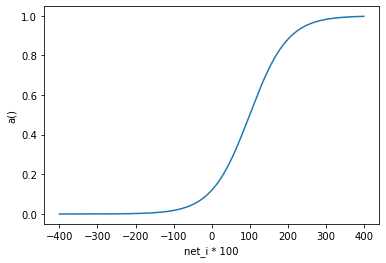

In [6]:
#Create activation function so that activation can't be negative but weights can be (allowing weights to facilitate inh)
    #a logistic activation function kind of treats a neuron as having some basal firing rate (so net_i = 0 means act = 0.5) that can be increased or decreased based on inputs

#Manually define the components of the piece-wise logistic function
b = np.linspace(-400, 400, 800);
af = 1/(1 + np.exp(0.02*(-b+100))); #0.02 makes logistic flatter, and +250 shifts it right so net_i = 0 gives a lower than 0.5 activation

ai = np.zeros(n) #initialize an array 'ai' for generating output array later

def act(net_i):

    #if a net input is greater than |1|, force it to be |0.99| so it can index properly
    net_i[net_i > 4] = 3.99;
    net_i[net_i < -4] = -3.99;
    
    for j in range(size(net_i)):
        
        ai[j] = af[int(net_i[j]*100)+400] #take the current weight, multiply by 100 and add 400 (this translates net_i into index of af, since af has 800 indices), then cast as int to use as index in af[]
        
    return ai

#Visualize a
plt.plot(b, af)
plt.xlabel("net_i * 100")
plt.ylabel("a()")
plt.show()

Odor trials


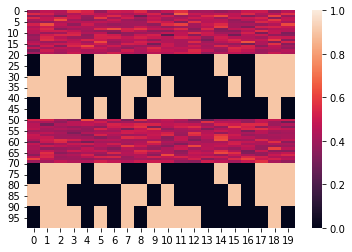

In [8]:
#Generate a time-variant odor series, with periods of odor input and spont act during rest period

"""
- try spont act in neurons themselves irrespective of LOT (that way you don't just have cells with similar input firing together via LOT, but rather via ASSN)
"""

#Define number of time steps for trial
t_range = 100;

#Create odor input time series
"""
odor = np.random.normal(0.2,0.5,size=(1,glom)); #Arbitrary test odor
odor[odor < 0] = 0; #remove negative values for odor

odor1 = np.random.normal(0.2,0.5,size=(1,glom)); #Arbitrary test odor
odor1[odor1 < 0] = 0; #remove negative values for odor

odor2 = np.random.normal(0.2,0.5,size=(1,glom)); #Arbitrary test odor
odor2[odor2 < 0] = 0; #remove negative values for odor
"""

#Create odor blocks that are more clearly defined rather than graded
mag = 0.9 #magnitude of input to LOT weights

odor = np.zeros(glom)
shuffled = array(range(glom)) 
np.random.shuffle(shuffled) #create a random permutation of 1:glom

for i in range(int(len(shuffled)/2)): #sparsify odor by making activating 1/4 of gloms
    odor[shuffled[i]] = mag
    
odor1 = np.zeros(glom)
shuffled = array(range(glom))
np.random.shuffle(shuffled)
for i in range(int(len(shuffled)/2)):
    odor1[shuffled[i]] = mag
    
odor2 = np.zeros(glom)
shuffled = array(range(glom))
np.random.shuffle(shuffled)
for i in range(int(len(shuffled)/2)):
    odor2[shuffled[i]] = mag

#bg spont act drawn from Poisson with mean intensity as odor
odor_total = [odor,odor1,odor2];
u = np.random.poisson(lam=mean(odor_total)*100,size=(t_range,glom))/100 


#Create blocks of odor for 100 trials
u[20:30,:] = odor
u[30:40,:] = odor1
u[40:50,:] = odor2
u[70:80,:] = odor
u[80:90,:] = odor1
u[90:100,:] = odor2
"""
#Create blocks of odor for 500 trials
u[20:40,:] = odor
u[40:60,:] = odor1
u[60:80,:] = odor2
u[200:220,:] = odor
u[220:240,:] = odor1
u[240:260,:] = odor2
u[400:420,:] = odor
u[420:440,:] = odor1
u[440:460,:] = odor2
"""

"""
odor = [0,0,1,0,1]
odor1 = [1,0,0,1,0]

for i in range(len(u)):
    
    if i % 2 == 0:
        
        u[i] = odor
    
    else:
        
        u[i] = odor1
"""    

#Print odor time series heatmap
print("Odor trials")
ax = sns.heatmap(u, vmin = 0, vmax = 1)
plt.show()

In [9]:
#Loop activity over time, updating the weights in act-dep fashion

#Construct new W_new to update weights without affecting the initial matrix (using W[:] copies all values, but doesn't pass the list by reference, ie. doesn't equate W_new and W such that W itself gets updated over iterations)
W_new = np.zeros(shape(W));
W_new[:] = W[:];

#Construct a matrix that has 1's where the are non-zero elements, and 0's where there are 0 elements; this way I don't have to loop through all elements later
W_ones = np.zeros(shape(W));
W_ones[:] = W[:];
W_ones[W_ones != 0] = 1;

#Instantiate matrices for storing activity over loop for printing later
neti_list = []
a_list = []
v_list = []

#Temp define bias weights
#b = np.random.rand(n)/4 + 0.6;

###############################################################################################
#Iterate over many time steps while updating weights

#Set threshold of "activity" for being counted as a "spike"
thres = 0.65;

for t in range(t_range):
    
    #Calculate input from LOT at time t
    u_lot = M.dot(u[t,:]);

    #Calculate input from ASSN following LOT-driven activity
    u_assn = W_new.dot(u_lot);
    
    #Sum input from LOT and ASSN, store in net input neti_list matrix
    neti = u_lot + u_assn; #for testing LOT + ASSN
    #neti = u_lot; #for testing LOT only 
    neti_list.append(copy.deepcopy(neti));
    #print("neti",neti)
    
    #Temp add bias weights to neti
    #neti = neti + b;
    
    """
    #Compute activation given net input, store in activation a_list matrix
    a = act(neti);
    a_list.append(copy.deepcopy(act(neti))) #deepcopy here is necessary bc append usually creates a shallow reference to 'a'; in the next time step when we update 'a', it will also update the previous timestep's reference of 'a' in the list
    #print("a",a)
    
    #Threshold a() via ReLU
    a[a < 0.2] = 0;
    a[a > 0.2] -= 0.2;
    
    #Increase weight as a 
    #for i in range(len(v)):
    """       
    
    #Binarize v into firing (1) or not firing (0), add to the v_list matrix
    v = np.zeros(n);
    #v[:] = a[:]
    v[:] = neti[:];
    v[v < thres] = 0;
    v[v >= thres] = 1;
    v_list.append(v) #append activity vector as a row to the activity matrix v_list
    #print("v",v)
    
    """
    #Run spont act in Pir layer on some trials (simulate spontaneous network bursts)
    spontrange = [16,17,18,19];
    
    if (t % 20) == 15: #for every 10 trials, have a network burst of 3 trials; this sets the network burst ensemble
        v = np.zeros(n);
        v = np.random.binomial(1,0.1,n); #creates a random array where 10% of the neurons have activity = 1
        v_list.append(v);
        
    elif (t % 20) in spontrange:
        
        v_list.append(v); #this just keeps the same v from the previous trial
        
    else: #for other trials, get v from LOT + ASSN as usual
        
        v = np.zeros(n);
        v[:] = neti[:];
        v[v < thres] = 0;
        v[v >= thres] = 1;
        v_list.append(v) #append activity vector as a row to the activity matrix v_list
        
    """
    
    #Update weights with the following loop based on 'v'
    for i in range(len(v)):
        
        #If neuron j is not firing
        if v[i] == 0:
            
            #Loop through all later neurons
            for j in range(len(v)):
                
                #If neuron k is firing (and k != j, so we don't update autapses)
                if v[j] == 1 and i != j and W_new[i,j] != 0: #ignoring synapses that are already 0, since those have no connectivity; also adding some stochasticity to weight changes
                    
                    #Decrease the weight by dz (see sig() above) in order to create logistic growth of ASSN weight
                    W_new[i,j] -= 0.2*sig(W_new[i,j]); #scale by 0.2 so we don't get runaway inh weights from attractor cells to inhibit all other cells
                    
        #If neuron j is firing
        elif v[i] == 1:
            
            #Loop through all other neurons
            for j in range(len(v)):
                
                #If neuron k is firing (and k != j, so we don't update autapses)
                if v[j] == 1 and i != j and W_new[i,j] != 0: #ignoring synapses that are already 0, since those have no connectivity; also adding some stochasticity to weight changes
                    
                    #Increase the weight by dz (see sig() above) in order to create logistic decay of ASSN weight
                    W_new[i,j] += sig(W_new[i,j]); 
    
    """
    #Introduce weight noise every 5 time steps
    if t % 5 == 0:
        
        #weight_noise = 1e-03; #based off weight change ~9e-6 per trial, so this is 5x of total weight change over 5 trials (to account for all the units that never fired)
        weight_noise = 0.5 #this iteration of weight_noise is to make the noise scale by a factor of weight_noise wrt to the current synaptic weight (this punishes attractor units more)
        
        #Generate a noise matrix of random +/-weight_noise, only at the non-zero elements of the weight matrix
        noise_mat = np.random.binomial(1,0.5,size=(n,n));
        noise_mat[noise_mat == 0] = -1;
        noise_mat = np.multiply(noise_mat,W_ones)*weight_noise; #this does unitwise multiplication of a random noise_mat matrix with W_ones to make all the 0-weight elements 0, then scales the remaining elements by weight_noise
        noise_mat = np.multiply(noise_mat,W_new); #this does unitwise multiplication of noise_mat by W_new, to generate a matrix where the noise is proportional to the synaptic weight
        
        #Add noise matrix to weight matrix
        W += noise_mat    
        
        #Note = since this loops through all neurons, it already takes care of updating both symmetric/reciprocal synapses IF THEY'RE BOTH FIRING (but doesn't have to be reciprocal updating if one is firing and the other isn't, because LTD doesn't apply to all of a firing cell's inactive input synapses)
        #although we COULD update LTD globally, which would implement a global downscaling... but it's probably better to do that in  dedicated code so I can keep the norm of inputs constant
    
        #Update weights based on correlation between 'a' vectors      
        
    #Export time series of heatmaps
    plt.imshow(W_new)
    plt.savefig("{t}.png".format(t=t))
    """
    
print("Done")

Done


neti_list = 


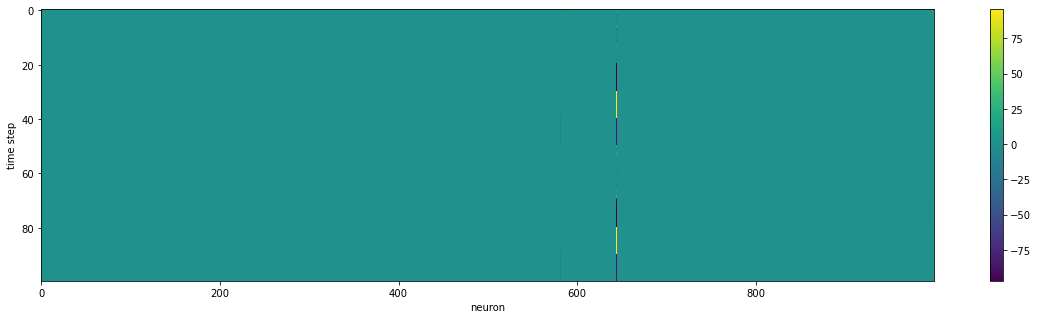

neti_list shortened = 


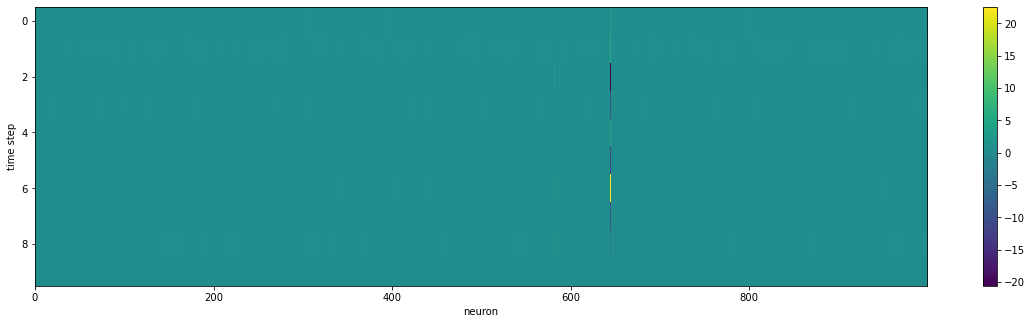

v_list = 


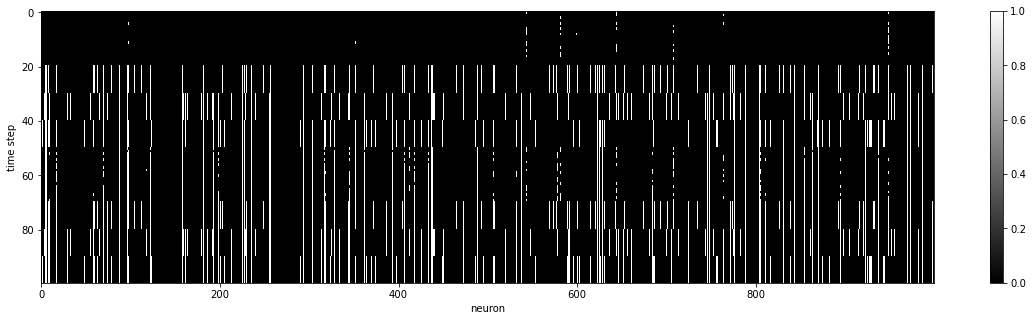

In [10]:
#Print activity matrices for viewing

print("neti_list = ")
plt.figure(figsize=(20,5))
plt.matshow(neti_list,fignum=0,cmap="viridis",aspect="auto") #matshow() properly displays firing v_list without condensing and glitching
plt.ylabel('time step')
plt.xlabel('neuron')
plt.colorbar()
plt.gca().xaxis.tick_bottom() #moves x-axis to bottom of image
plt.show()

print("neti_list shortened = ")
plt.figure(figsize=(20,5))
plt.matshow(neti_list[0:10],fignum=1,cmap="viridis",aspect="auto") #matshow() properly displays firing v_list without condensing and glitching
plt.ylabel('time step')
plt.xlabel('neuron')
plt.colorbar()
plt.gca().xaxis.tick_bottom() #moves x-axis to bottom of image
plt.show()   

"""
#Print activity matrix for viewing
print("a_list = ")
ax = sns.heatmap(a_list[0:1000])
plt.ylabel('time step')
plt.xlabel('neuron')
plt.show()

"""
#Print activity matrix for viewing
print("v_list = ")
plt.figure(figsize=(20,5))
plt.matshow(v_list,fignum=0,cmap="gray",aspect="auto") #matshow() properly displays firing v_list without condensing and glitching
plt.ylabel('time step')
plt.xlabel('neuron')
plt.colorbar()
plt.gca().xaxis.tick_bottom() #moves x-axis to bottom of image
plt.show()

In [288]:
#Script for ranking neurons with higher mean/total LOT/ASSN weights, and seeing if they coincide with the most active neurons in v_list

#Rank neurons with highest mean or total LOT inputs
LOT_mean = np.zeros((n,2))
LOT_mean[:,0] = range(n) #create a column for indexing the neurons
LOT_mean[:,1] = np.mean(M,axis=1).tolist() #take the mean of the rows (axis 0 is columns, 1 is rows)
LOT_mean = sorted(LOT_mean, key=lambda tup: tup[1], reverse=True) #sort by the second column (or the index 1 in the tuple, where each row is a tuple); this sorts by the value, not the index; reverse makes this descending sorting

LOT_total = np.zeros((n,2))
LOT_total[:,0] = range(n)
LOT_total[:,1] = np.sum(M,axis=1).tolist()
LOT_total = sorted(LOT_total, key=lambda tup: tup[1], reverse=True)

#Rank neurons with highest mean or total ASSN inputs
ASSN_mean = np.zeros((n,2))
ASSN_mean[:,0] = range(n)
ASSN_mean[:,1] = np.mean(W,axis=1).tolist()
ASSN_mean = sorted(ASSN_mean, key=lambda tup: tup[1], reverse=True)

ASSN_total = np.zeros((n,2))
ASSN_total[:,0] = range(n)
ASSN_total[:,1] = np.sum(W,axis=1).tolist()
ASSN_total = sorted(ASSN_total, key=lambda tup: tup[1], reverse=True)

#Rank neurons in v_list with highest activity
v_mean = np.zeros((n,2))
v_mean[:,0] = range(n)
v_mean[:,1] = np.mean(v_list,axis=0).tolist()
v_mean = sorted(v_mean, key=lambda tup: tup[1], reverse=True)

v_total = np.zeros((n,2))
v_total[:,0] = range(n)
v_total[:,1] = np.sum(v_list,axis=0).tolist()
v_total = sorted(v_total, key=lambda tup: tup[1], reverse=True)

print("LOT total")
display(LOT_total[0:21])

print("ASSN total")
display(ASSN_total[0:21])

print("Most active neurons")
display(v_total[0:21])

LOT total


[array([471.,   1.]),
 array([21.,  1.]),
 array([22.,  1.]),
 array([28.,  1.]),
 array([38.,  1.]),
 array([41.,  1.]),
 array([50.,  1.]),
 array([61.,  1.]),
 array([67.,  1.]),
 array([74.,  1.]),
 array([77.,  1.]),
 array([79.,  1.]),
 array([80.,  1.]),
 array([82.,  1.]),
 array([83.,  1.]),
 array([94.,  1.]),
 array([95.,  1.]),
 array([99.,  1.]),
 array([102.,   1.]),
 array([107.,   1.]),
 array([145.,   1.])]

ASSN total


[array([404.        ,  68.97476671]),
 array([163.        ,   5.92991793]),
 array([123.        ,   5.62705548]),
 array([517.      ,   4.312089]),
 array([894.        ,   4.11403635]),
 array([897.        ,   3.76034166]),
 array([723.       ,   3.6769826]),
 array([226.        ,   3.48648145]),
 array([84.        ,  3.13686046]),
 array([876.        ,   3.10972119]),
 array([295.        ,   2.75112346]),
 array([460.        ,   2.70714815]),
 array([466.        ,   2.50187381]),
 array([431.        ,   2.20998541]),
 array([154.        ,   2.04529634]),
 array([122.       ,   1.9889395]),
 array([612.        ,   1.87754634]),
 array([344.        ,   1.74180353]),
 array([471.        ,   1.65675113]),
 array([420.        ,   1.64949533]),
 array([319.        ,   1.53537353])]

Most active neurons


[array([928.,  48.]),
 array([404.,  22.]),
 array([112.,  15.]),
 array([127.,  15.]),
 array([502.,  15.]),
 array([529.,  15.]),
 array([568.,  15.]),
 array([656.,  15.]),
 array([678.,  15.]),
 array([682.,  15.]),
 array([832.,  15.]),
 array([838.,  15.]),
 array([849.,  15.]),
 array([943.,  15.]),
 array([ 8., 10.]),
 array([15., 10.]),
 array([20., 10.]),
 array([28., 10.]),
 array([44., 10.]),
 array([51., 10.]),
 array([67., 10.])]

Pre-update W symmetry index =  1.9779744480032533
Pre-update heatmap


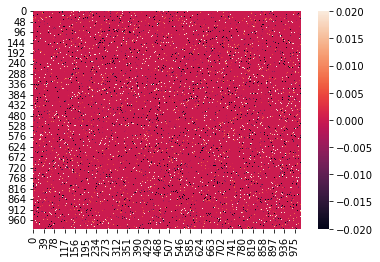

Post-update W symmetry index =  1.9747424774303937
Post-update ASSN weights


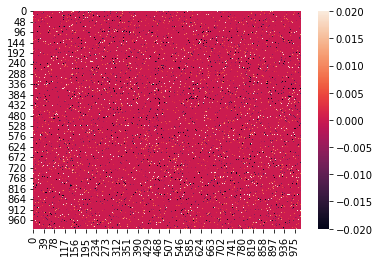

W_diff heatmap


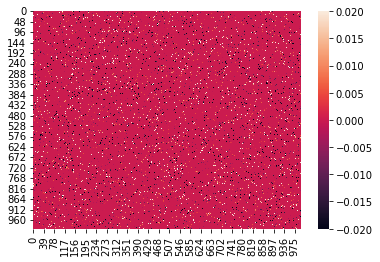

Mean of W_diff =  0.002720413201496107


"\n#Truncate W_diff weights to two decimal points (for easy viewing)\nfor i in range(len(W_diff)):\n    for j in range(len(W_diff[i])):\n        W_diff[i,j] = math.trunc(W_diff[i,j]*100)/100 #this /100 * 100 is bc trunc() cuts off all decimal pts, so here we force it to cut to 2 decimal points\n\nprint('W_diff = ')\nprint(W_diff)\n"

In [231]:
#Script for printing our pre-update and post-update metrics

###############################################################################################
#Get pre-update metrics

#Get rough estimate for symmetry of the pre-update matrix
#get the mean of the matrix - matrix^T (since symmetric matrix should have a mean of 0); np.absolute gets rid of negative values, so we have a positive index; this index is also normalized to mean(W), so differences don't just scale up with increasing weights after updating
pre_W_mean = mean(np.absolute(W - W.transpose()))/mean(np.absolute(W))
print("Pre-update W symmetry index = ", pre_W_mean)


#Visualize ASSN as heatmap (with heatmap anchored at weights of 0 and 1)
"""
print("Pre-update ASSN weights = ")
print(W)
"""

print("Pre-update heatmap")
ax = sns.heatmap(W, vmin = -0.02, vmax = 0.02)
plt.show()

###############################################################################################
#Get post-update metrics

#Get rough estimate for symmetry of the post-update matrix
#get the mean of the matrix - matrix^T (since symmetric matrix should have a mean of 0); np.absolute gets rid of negative values, so we have a positive index; this index is also normalized to mean(W), so differences don't just scale up with increasing weights after updating
post_W_mean = mean(np.absolute(W_new - W_new.transpose()))/mean(np.absolute(W_new))
print("Post-update W symmetry index = ", post_W_mean)

"""
#Truncate W_new weights to two decimal points (for easy viewing)
for i in range(len(W_new)):
    for j in range(len(W_new[i])):
        W_new[i,j] = math.trunc(W_new[i,j]*100)/100 #this /100 * 100 is bc trunc() cuts off all decimal pts, so here we force it to cut to 2 decimal points

print('Post-update W = ')
print(W_new)
"""

#Visualize ASSN as heatmap (with heatmap anchored at weights of 0 and 1)
print("Post-update ASSN weights")
ax = sns.heatmap(W_new, vmin = -0.02, vmax = 0.02)
plt.show()

#Get difference between pre- and post-update weights, and visualize via heatmap
W_diff = W_new - W

print("W_diff heatmap")
ax = sns.heatmap(W_diff, vmin = -0.02, vmax = 0.02)
plt.show()

print("Mean of W_diff = ", mean(W_diff[W != 0])) #only consider elements that weren't 0 in the original weights matrix, since those weights won't have changed
        
"""
#Truncate W_diff weights to two decimal points (for easy viewing)
for i in range(len(W_diff)):
    for j in range(len(W_diff[i])):
        W_diff[i,j] = math.trunc(W_diff[i,j]*100)/100 #this /100 * 100 is bc trunc() cuts off all decimal pts, so here we force it to cut to 2 decimal points

print('W_diff = ')
print(W_diff)
"""

In [82]:
#Eigendecomposition and analysis of W and W_new

LA.eig(W);

iden = np.identity(5)
display(iden)

LA.eig(iden)

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

(array([1., 1., 1., 1., 1.]),
 array([[1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.]]))